In [1]:
import matplotlib.pyplot as plt
from PIL import Image
import glob

from fastai.vision import *
from fastai import *
import pandas as pd

import tarfile
import scipy.io
import numpy as np
import cv2 as cv
import os
import shutil
import random

# Overview

Our goal for this project is to create a model for identifying cars by make, model and year.  The data is split into 8,144 training images and 8,041 testing images.  The data has 196 classes with all the training images divided evenly between them

In [7]:
dict(list(scipy.io.loadmat('/home/amccarthy13/Documents/cars_dataset/cars_annos.mat').items())[0:5])

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Sat Feb 28 19:34:55 2015',
 '__version__': '1.0',
 '__globals__': [],
 'annotations': array([[(array(['car_ims/000001.jpg'], dtype='<U18'), array([[112]], dtype=uint8), array([[7]], dtype=uint8), array([[853]], dtype=uint16), array([[717]], dtype=uint16), array([[1]], dtype=uint8), array([[0]], dtype=uint8)),
         (array(['car_ims/000002.jpg'], dtype='<U18'), array([[48]], dtype=uint8), array([[24]], dtype=uint8), array([[441]], dtype=uint16), array([[202]], dtype=uint8), array([[1]], dtype=uint8), array([[0]], dtype=uint8)),
         (array(['car_ims/000003.jpg'], dtype='<U18'), array([[7]], dtype=uint8), array([[4]], dtype=uint8), array([[277]], dtype=uint16), array([[180]], dtype=uint8), array([[1]], dtype=uint8), array([[0]], dtype=uint8)),
         ...,
         (array(['car_ims/016183.jpg'], dtype='<U18'), array([[25]], dtype=uint8), array([[32]], dtype=uint8), array([[587]], dtype=uint16), array([[359]], dt

In [8]:
scipy.io.loadmat('/home/amccarthy13/Documents/cars_dataset/cars_test_annos_withlabels.mat')

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Sat Dec 14 14:13:07 2013',
 '__version__': '1.0',
 '__globals__': [],
 'annotations': array([[(array([[30]], dtype=uint8), array([[52]], dtype=uint8), array([[246]], dtype=uint8), array([[147]], dtype=uint8), array([[181]], dtype=uint8), array(['00001.jpg'], dtype='<U9')),
         (array([[100]], dtype=uint8), array([[19]], dtype=uint8), array([[576]], dtype=uint16), array([[203]], dtype=uint8), array([[103]], dtype=uint8), array(['00002.jpg'], dtype='<U9')),
         (array([[51]], dtype=uint8), array([[105]], dtype=uint8), array([[968]], dtype=uint16), array([[659]], dtype=uint16), array([[145]], dtype=uint8), array(['00003.jpg'], dtype='<U9')),
         ...,
         (array([[33]], dtype=uint8), array([[27]], dtype=uint8), array([[602]], dtype=uint16), array([[252]], dtype=uint8), array([[17]], dtype=uint8), array(['08039.jpg'], dtype='<U9')),
         (array([[33]], dtype=uint8), array([[142]], dtype=uint8), arra

# Processing

This portion of the code is for cropping the images and organizing them into train and test folders and into folders for their respective classes.  This makes it easy to use Fast.ai to train models.

In [23]:
def save_train_data(fnames, labels, bboxes):
    src_folder = '/home/amccarthy13/Documents/cars_dataset/cars_train/'
    num_samples = len(fnames)
    
    train_split = 0.8
    num_train = int(round(num_samples * train_split))
    train_indexes = random.sample(range(num_samples), num_train)
    
    
    for i in range(num_samples):
        fname = fnames[i]
        label = labels[i]
        (x1, y1, x2, y2) = bboxes[i]
        
        src_path = os.path.join(src_folder, fname)
        src_image = cv.imread(src_path)
        height, width = src_image.shape[:2]
        
        margin = 16
        x1 = max(0, x1-margin)
        y1 = max(0, y1-margin)
        x2 = min(x2 + margin, width)
        y2 = min(y2 + margin, height)
        
        if i in train_indexes:
            dst_folder = '/home/amccarthy13/Documents/cars_dataset/train/'
        else:
            dst_folder = '/home/amccarthy13/Documents/cars_dataset/valid/'
            
        dst_path = os.path.join(dst_folder, label)
        if not os.path.exists(dst_path):
            os.makedirs(dst_path)
        dst_path = os.path.join(dst_path, fname)
        
        crop_image = src_image[y1:y2, x1:x2]
        dst_img = cv.resize(src=crop_image, dsize=(img_height, img_width))
        cv.imwrite(dst_path, dst_img)
        
    print("All train data saved.") 
        
def save_test_data(fnames, bboxes):
    src_folder = '/home/amccarthy13/Documents/cars_dataset/cars_test/'
    dst_folder = '/home/amccarthy13/Documents/cars_dataset/test/'
    num_samples = len(fnames)
    
    for i in range(num_samples):
        fname = fnames[i]
        (x1, y1, x2, y2) = bboxes[i]
        
        src_path = os.path.join(src_folder, fname)
        src_image = cv.imread(src_path)
        height, width = src_image.shape[:2]
        
        margin = 16
        x1 = max(0, x1-margin)
        y1 = max(0, y1-margin)
        x2 = min(x2 + margin, width)
        y2 = min(y2 + margin, height)
        
        dst_path = os.path.join(dst_folder, fname)
        if not os.path.exists(dst_path):
            os.makedirs(dst_path)
        crop_image = src_image[y1:y2, x1:x2]
        dst_img = cv.resize(src=crop_image, dsize=(img_height, img_width))
        cv.imwrite(dst_path, dst_img)
      
      
    print("All test data saved.") 
        
def process_train_data():
    cars_annos = scipy.io.loadmat('/home/amccarthy13/Documents/cars_dataset/devkit/cars_train_annos.mat')
    annotations = cars_annos['annotations']
    annotations = np.transpose(annotations)
    
    fnames = []
    class_ids = []
    bboxes = []
    labels = []
    
    for annotation in annotations:
        bbox_x1 = annotation[0][0][0][0]
        bbox_y1 = annotation[0][1][0][0]
        bbox_x2 = annotation[0][2][0][0]
        bbox_y2 = annotation[0][3][0][0]
        class_id = annotation[0][4][0][0]
        labels.append('{}'.format(class_names[class_id-1][0][0]))
        fname = annotation[0][5][0]
        bboxes.append((bbox_x1, bbox_y1, bbox_x2, bbox_y2))
        class_ids.append(class_id)
        fnames.append(fname)
        
    labels_count = np.unique(class_ids).shape[0]
    print('car count: %d' % labels_count)
    
    save_train_data(fnames, labels, bboxes)
    
def process_test_data():
    cars_annos = scipy.io.loadmat('/home/amccarthy13/Documents/cars_dataset/devkit/cars_test_annos.mat')
    annotations = cars_annos['annotations']
    annotations = np.transpose(annotations)
    
    fnames = []
    bboxes = []
    
    for annotation in annotations:
        bbox_x1 = annotation[0][0][0][0]
        bbox_y1 = annotation[0][1][0][0]
        bbox_x2 = annotation[0][2][0][0]
        bbox_y2 = annotation[0][3][0][0]
        fname = annotation[0][4][0]
        bboxes.append((bbox_x1, bbox_y1, bbox_x2, bbox_y2))
        fnames.append(fname)
        
    save_test_data(fnames, bboxes)

In [24]:
cars_meta = scipy.io.loadmat('/home/amccarthy13/Documents/cars_dataset/devkit/cars_meta')
class_names = cars_meta['class_names']
class_names = np.transpose(class_names)

img_width, img_height = 224, 224

#process_train_data()
process_test_data()

All test data saved.


# First Model

The first model I trained was a resnet34 model using default fast ai data augmentations.  I also normalized the images with imagenet_stats.  I was able to achieve around 84% accuracy

In [42]:
data_notfms = ImageDataBunch.from_folder('/home/amccarthy13/Documents/cars_dataset/','train','valid',ds_tfms=get_transforms(), size=226).normalize(imagenet_stats)

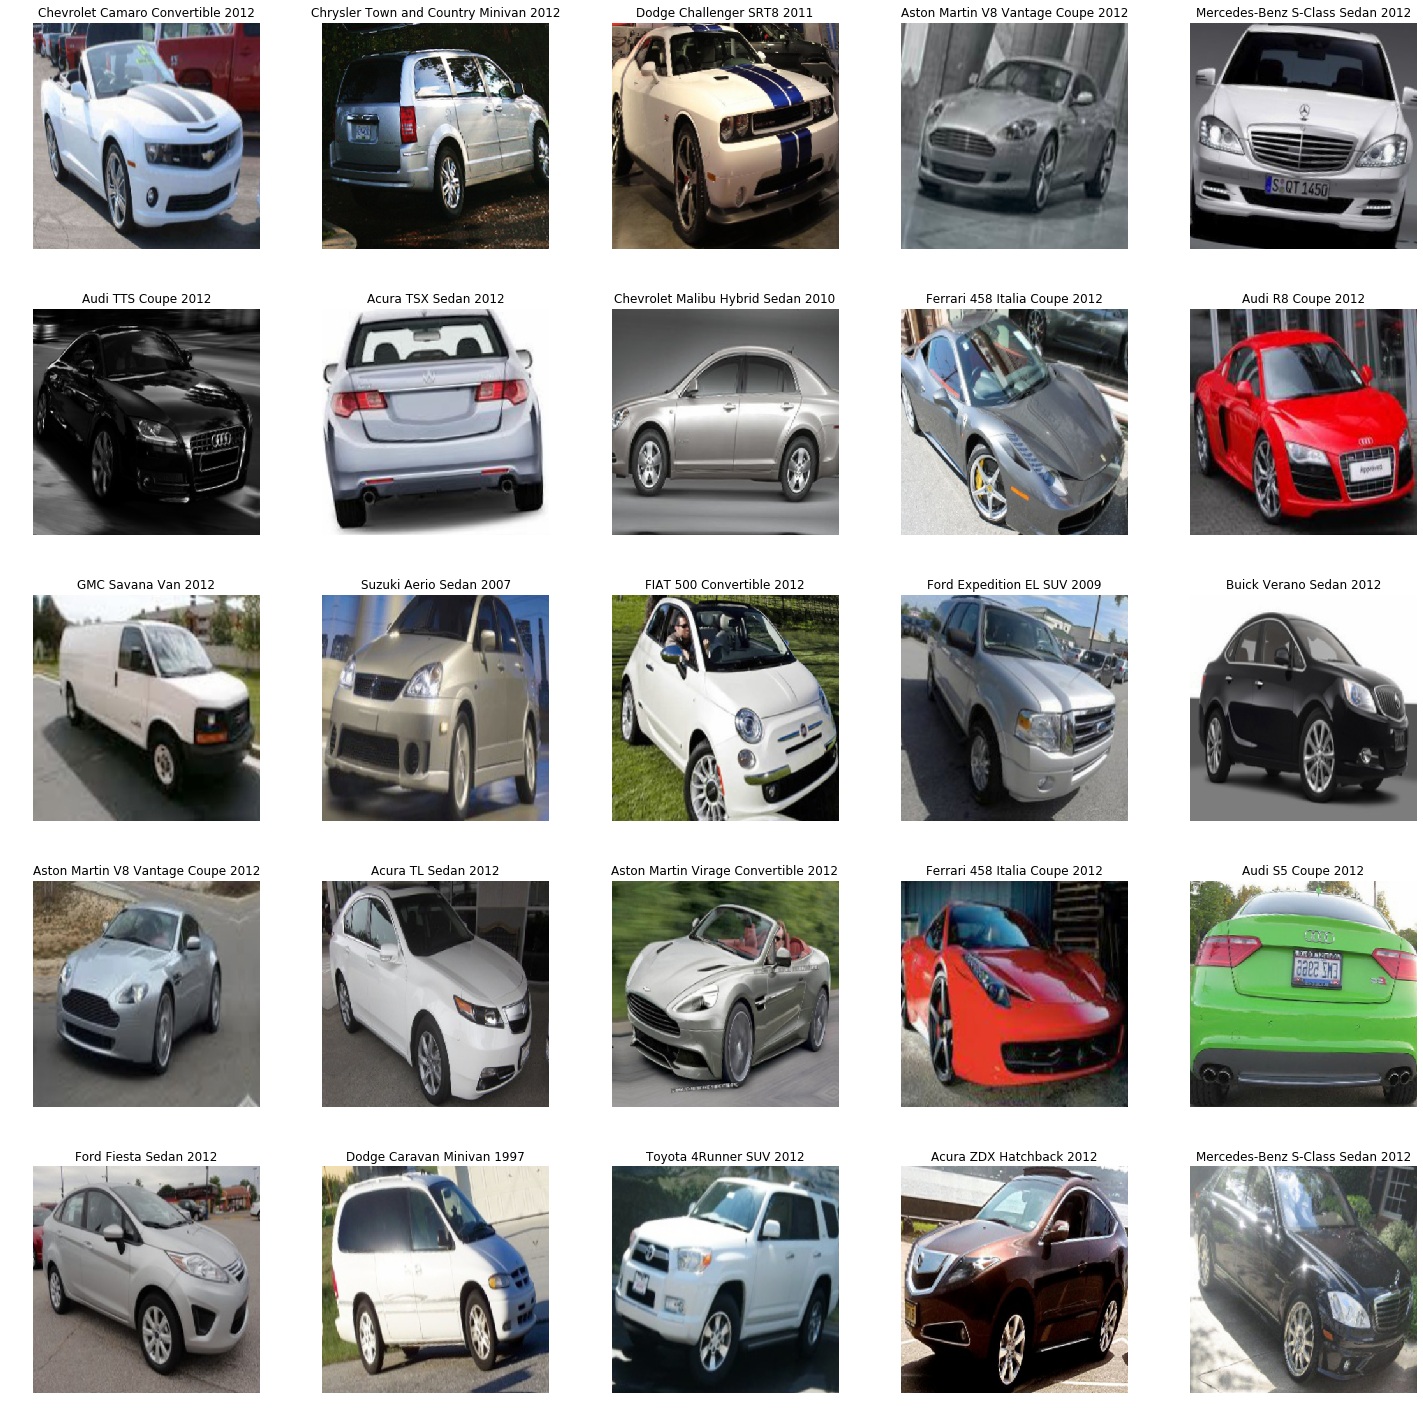

In [26]:
data_notfms.show_batch()

In [27]:
len(data_notfms.classes)

196

In [33]:
images = Path('/home/amccarthy13/Documents/cars_dataset/train')
learn = create_cnn(data_notfms, models.resnet34, metrics=[accuracy, error_rate])

In [34]:
learn.lr_find()
learn.recorder.plot()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


KeyboardInterrupt: 

In [6]:
learn.fit_one_cycle(4, 1.58E-02)

epoch,train_loss,valid_loss,accuracy,error_rate,time
1,4.160892,4.065290,0.168815,0.831185,00:27
2,2.840104,2.471272,0.394107,0.605893,00:27
3,1.753587,1.115343,0.678944,0.321056,00:27
4,1.046070,0.856583,0.757520,0.242480,00:27


In [7]:
learn.save('no_tfms_1')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


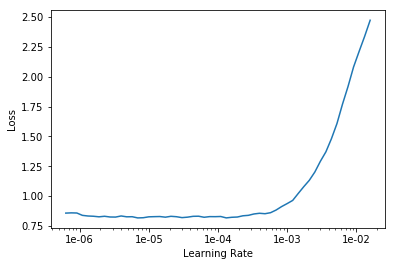

In [8]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [10]:
learn.fit_one_cycle(4, max_lr=slice(1e-5,1e-4))

epoch,train_loss,valid_loss,accuracy,error_rate,time
1,0.822274,0.740327,0.797422,0.202578,00:36
2,0.674676,0.653199,0.828115,0.171885,00:36
3,0.559412,0.618727,0.839779,0.160221,00:36
4,0.494000,0.604285,0.841621,0.158379,00:36


## Test Time Augmentation

After training each model I performed a test time augmentation to attempt to increase accuracy.

In [11]:
log_preds, y = learn.TTA()
prob = np.exp(log_preds)
accuracy(log_preds, y)

tensor(0.8373)

In [12]:
learn.save('no_tfms_2')

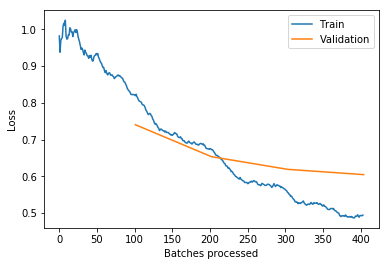

In [13]:
learn.recorder.plot_losses()

# Second Model

For this model I again used resnet 34 but I added my own augmentations in an attempt to achieve increased accuracy.  I achieved an accuracy of ~84%

In [14]:
xtra_tfms = [jitter(magnitude=0.01,p=0.5), squish(scale = 0.66)]
tfms = get_transforms(flip_vert=False,
                      do_flip=True,
                      max_rotate=30.0,
                      max_zoom=1.5,
                      max_lighting=0.4,
                      max_warp=0.4,
                      xtra_tfms=xtra_tfms)

data_tfms = ImageDataBunch.from_folder('/home/amccarthy13/Documents/cars_dataset/','train','valid',ds_tfms=tfms,size=356).normalize(imagenet_stats)
learn = create_cnn(data_tfms, models.resnet34, metrics=[accuracy, error_rate]).load('no_tfms_2')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


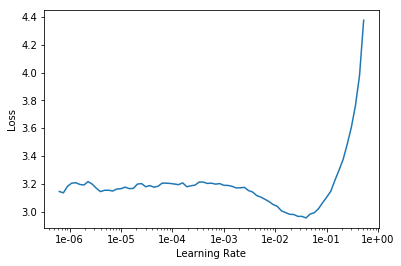

In [15]:
learn.lr_find()
learn.recorder.plot()

In [16]:
learn.fit_one_cycle(8, 1.5E-02)

epoch,train_loss,valid_loss,accuracy,error_rate,time
1,2.322334,1.103013,0.695519,0.304481,00:27
2,2.446406,2.777749,0.364027,0.635973,00:27
3,2.583934,1.735494,0.541436,0.458564,00:27
4,2.312815,1.618466,0.562308,0.437692,00:27
5,2.037499,1.313019,0.661142,0.338858,00:27
6,1.684761,0.940548,0.737262,0.262738,00:27
7,1.399728,0.851324,0.762431,0.237569,00:27
8,1.262705,0.831608,0.771639,0.228361,00:27


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


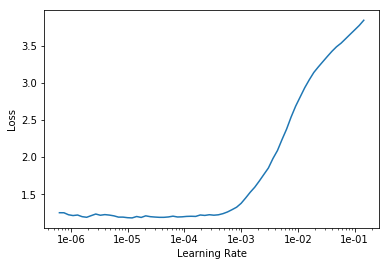

In [17]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [19]:
learn.fit_one_cycle(8, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,accuracy,error_rate,time
1,1.056868,0.753934,0.796194,0.203806,00:36
2,1.075295,0.740479,0.793738,0.206262,00:36
3,1.042295,0.734675,0.791283,0.208717,00:36
4,1.000099,0.721475,0.798036,0.201964,00:36
5,0.980843,0.707581,0.807244,0.192756,00:36
6,0.926828,0.699111,0.806016,0.193984,00:37
7,0.923747,0.692702,0.810927,0.189073,00:37
8,0.933654,0.693111,0.807858,0.192142,00:37


In [20]:
log_preds, y = learn.TTA()
prob = np.exp(log_preds)
accuracy(log_preds, y)

tensor(0.8422)

In [21]:
learn.save('tfms_1')

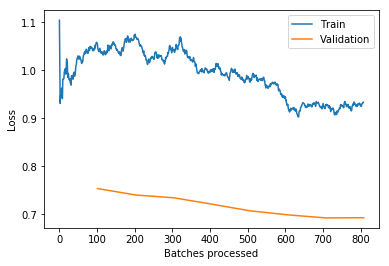

In [22]:
learn.recorder.plot_losses()

# Top Losses

Here I took a look at the top losses to see what classes the model was most frequently confusing with other ones 

In [23]:
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()
len(data_tfms.valid_ds)==len(losses)==len(idxs)

True

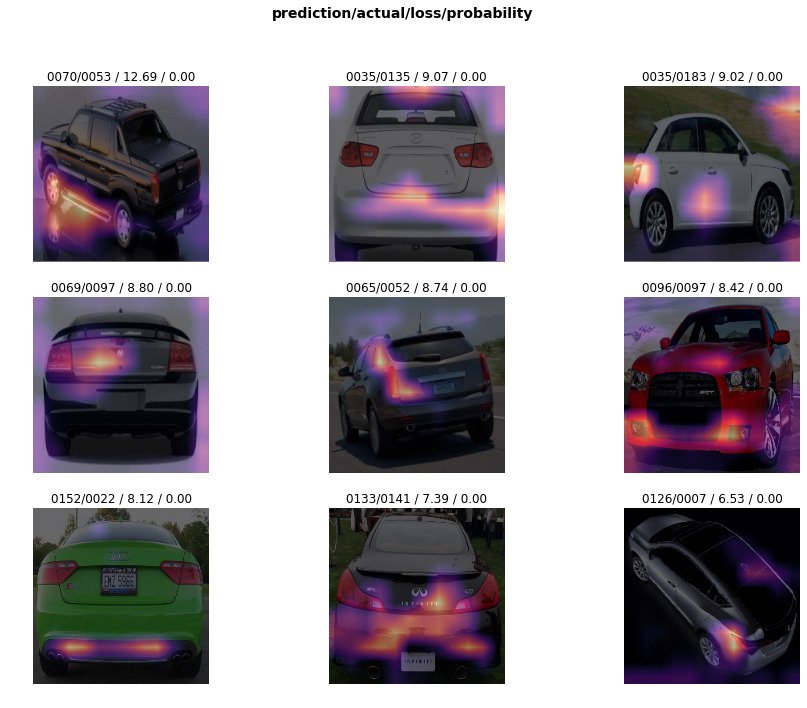

In [24]:
interp.plot_top_losses(9, figsize=(15,11))

In [25]:
interp.most_confused(min_val=2)

[('0084', '0083', 7),
 ('0069', '0075', 4),
 ('0083', '0084', 4),
 ('0097', '0096', 4),
 ('0104', '0103', 4),
 ('0166', '0088', 4),
 ('0008', '0010', 3),
 ('0014', '0019', 3),
 ('0016', '0017', 3),
 ('0074', '0069', 3),
 ('0103', '0104', 3),
 ('0176', '0177', 3),
 ('0008', '0009', 2),
 ('0017', '0016', 2),
 ('0018', '0017', 2),
 ('0022', '0013', 2),
 ('0022', '0021', 2),
 ('0025', '0019', 2),
 ('0030', '0029', 2),
 ('0031', '0038', 2),
 ('0043', '0042', 2),
 ('0046', '0045', 2),
 ('0050', '0133', 2),
 ('0054', '0074', 2),
 ('0061', '0073', 2),
 ('0066', '0067', 2),
 ('0071', '0064', 2),
 ('0119', '0064', 2),
 ('0119', '0071', 2),
 ('0120', '0062', 2),
 ('0164', '0165', 2),
 ('0177', '0156', 2),
 ('0177', '0175', 2)]

# Third Model

For this model, I used the resnet50 architecture and default fast ai data augmentations.  This model achieved the highest accuracy after TTA of around 89%

In [26]:
learn = create_cnn(data_notfms, models.resnet50, metrics=[accuracy, error_rate])

In [27]:
learn.fit_one_cycle(10, 1.58E-02)

epoch,train_loss,valid_loss,accuracy,error_rate,time
1,4.162150,2.770621,0.353591,0.646409,00:56
2,2.684980,3.374843,0.284837,0.715163,00:53
3,2.411635,3.010903,0.341314,0.658686,00:52
4,1.754582,2.017287,0.504604,0.495396,00:52
5,1.385107,1.822879,0.555556,0.444444,00:53
6,1.035026,1.105993,0.707182,0.292818,00:53
7,0.677968,0.713743,0.800491,0.199509,00:53
8,0.452028,0.573399,0.839779,0.160221,00:52
9,0.300061,0.480443,0.859423,0.140577,00:53
10,0.218807,0.468127,0.866176,0.133824,00:53


In [28]:
learn.save('50-notfms-1')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


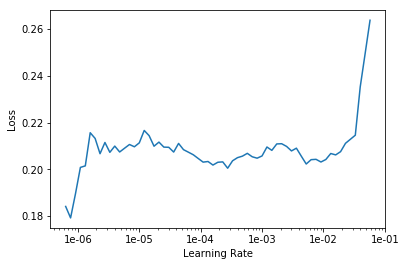

In [29]:
learn.lr_find()
learn.recorder.plot()

In [30]:
learn.unfreeze()
learn.fit_one_cycle(9, max_lr=slice(1e-5,1e-3))

epoch,train_loss,valid_loss,accuracy,error_rate,time
1,0.201790,0.487952,0.875384,0.124616,01:08
2,0.283813,0.646657,0.830571,0.169429,01:08
3,0.330253,0.797816,0.792511,0.207489,01:08
4,0.291570,0.542266,0.859423,0.140577,01:08
5,0.233554,0.527268,0.853898,0.146102,01:08
6,0.171548,0.436842,0.889503,0.110497,01:09
7,0.126351,0.403982,0.893800,0.106200,01:08
8,0.098632,0.392822,0.895642,0.104359,01:09
9,0.077346,0.390378,0.897483,0.102517,01:09


In [31]:
log_preds, y = learn.TTA()
prob = np.exp(log_preds)
accuracy(log_preds, y)

tensor(0.8987)

In [32]:
learn.save('50-notfms-2')

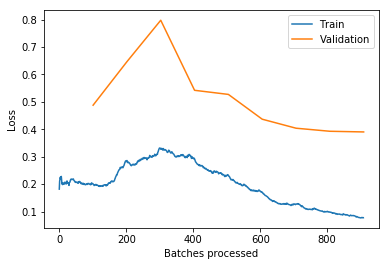

In [33]:
learn.recorder.plot_losses()

# Fourth Model

For this model I used my previous augmentations and the resnet50 architecture.  I achieved an accuracy of around  

In [34]:
learn = create_cnn(data_tfms, models.resnet50, metrics=[accuracy, error_rate]).load('50-notfms-2')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


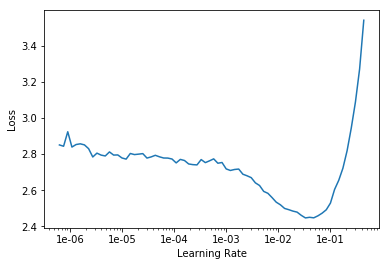

In [35]:
learn.lr_find()
learn.recorder.plot()

In [36]:
learn.fit_one_cycle(10, 1.5e-2)

epoch,train_loss,valid_loss,accuracy,error_rate,time
1,1.784531,0.595223,0.843462,0.156538,00:52
2,1.556458,1.093574,0.710252,0.289748,00:53
3,1.866157,1.340689,0.650706,0.349294,00:52
4,1.884765,1.351656,0.645181,0.354819,00:53
5,1.740434,1.222477,0.669736,0.330264,00:53
6,1.467444,1.001228,0.731123,0.268877,00:52
7,1.178816,0.768058,0.797422,0.202578,00:53
8,0.946076,0.594226,0.845918,0.154082,00:53
9,0.762910,0.538803,0.855740,0.144260,00:52
10,0.690406,0.527495,0.856967,0.143033,00:53


In [37]:
learn.save('50-tfms-1')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


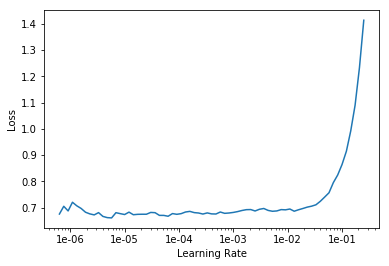

In [38]:
learn.lr_find()
learn.recorder.plot()

In [39]:
learn.unfreeze()
learn.fit_one_cycle(9, max_lr=slice(1e-5,1e-3))

epoch,train_loss,valid_loss,accuracy,error_rate,time
1,0.666401,0.522104,0.856967,0.143033,01:08
2,0.766022,0.662252,0.813996,0.186004,01:08
3,0.801648,0.670427,0.820749,0.179251,01:08
4,0.739219,0.600282,0.835482,0.164518,01:08
5,0.633500,0.577130,0.845304,0.154696,01:09
6,0.590386,0.495011,0.870473,0.129527,01:08
7,0.509589,0.457705,0.877839,0.122161,01:08
8,0.447493,0.445408,0.880909,0.119091,01:09
9,0.418973,0.441036,0.884592,0.115408,01:08


In [40]:
log_preds, y = learn.TTA()
prob = np.exp(log_preds)
accuracy(log_preds, y)

tensor(0.8950)

In [41]:
learn.save('50-tfms-2')

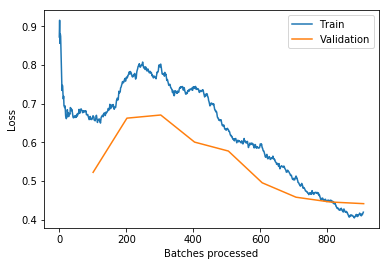

In [42]:
learn.recorder.plot_losses()

# Conclusion

The resnet34 model achieved an accuracy of 84% with or without augmentations and the resnet50 model achieved an accuracy of 89% with or without transformations.  The next step for this project is to conference with the group and come up with ways to increase the accuracy of the model to at or above SOTA levels (~94%)

In [43]:
learn = create_cnn(data_notfms, models.resnet152, metrics=[accuracy, error_rate])

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


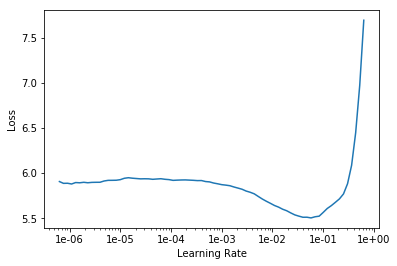

In [44]:
learn.lr_find()
learn.recorder.plot()

In [45]:
learn.fit_one_cycle(10, 1e-2)

epoch,train_loss,valid_loss,accuracy,error_rate,time
1,4.306412,3.109821,0.278085,0.721915,00:51
2,2.596755,3.578439,0.248619,0.751381,00:50
3,2.320024,3.447082,0.286065,0.713935,00:50
4,1.753922,2.192595,0.448742,0.551258,00:50
5,1.349397,1.402082,0.628606,0.371394,00:51
6,1.028824,1.424632,0.605893,0.394107,00:51
7,0.703682,0.740051,0.785758,0.214242,00:51
8,0.458499,0.515619,0.850215,0.149785,00:51
9,0.310046,0.471073,0.858809,0.141191,00:51
10,0.244339,0.442304,0.868017,0.131983,00:51


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


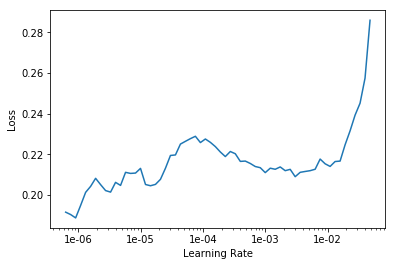

In [46]:
learn.lr_find()
learn.recorder.plot()

In [47]:
learn.unfreeze()
learn.fit_one_cycle(9, max_lr=slice(1e-4,1e-3))

epoch,train_loss,valid_loss,accuracy,error_rate,time
1,0.352702,0.821302,0.763045,0.236955,01:07
2,0.810825,1.450045,0.607121,0.392879,01:09
3,0.797981,1.259883,0.665439,0.334561,01:08
4,0.611781,0.860854,0.750767,0.249233,01:08
5,0.492454,0.611063,0.809085,0.190915,01:08
6,0.323970,0.489679,0.855740,0.144260,01:08
7,0.211368,0.376282,0.885819,0.114180,01:08
8,0.141311,0.331879,0.895642,0.104359,01:08
9,0.109106,0.326012,0.896255,0.103745,01:08


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


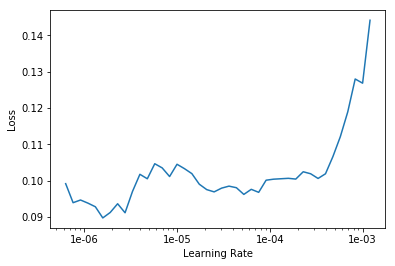

In [49]:
learn.lr_find()
learn.recorder.plot()

In [50]:
learn.unfreeze()
learn.fit_one_cycle(9, max_lr=slice(1e-5,1e-4))

epoch,train_loss,valid_loss,accuracy,error_rate,time
1,0.106840,0.319004,0.899939,0.100061,01:06
2,0.107886,0.317419,0.898711,0.101289,01:07
3,0.100538,0.330121,0.906077,0.093923,01:08
4,0.097825,0.315681,0.905463,0.094537,01:08
5,0.086105,0.305388,0.906077,0.093923,01:08
6,0.080937,0.297731,0.904850,0.095150,01:08
7,0.067951,0.294552,0.911602,0.088398,01:08
8,0.058033,0.291435,0.910988,0.089012,01:08
9,0.059030,0.292863,0.912216,0.087784,01:08


In [51]:
log_preds, y = learn.TTA()
prob = np.exp(log_preds)
accuracy(log_preds, y)

tensor(0.9153)